
Лабараторная работа № 5 
==============================================
**Студент**: Гамов Павел м80-407б-18

Для начала повторим то же что и было в примере. Инициализируем все наши функции, создадим датасеты и даталоадеры, натренеруем модель.


In [1]:
%matplotlib inline
# from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

Загружаем данные
---------

Я использую датасет с двумя классами, фотографии здоровых и больных легких во время пневмонии. `<https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia>`. Пришлось удалять некоторые фотографии из за повторений, а так же снизить общее число фотографий, изначально их кол-во было больше 4-х тысяч фотографий.



Немного изменим загрузку данных. Я загрузил все в 1 датасет и резделил его на трейн и вал. Ко всем данным применим только 1 трансформацию.

In [2]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

full_image_datasets = datasets.ImageFolder(os.path.join('', 'chest_xray'),
                                          data_transform)

image_datasets_list = torch.utils.data.random_split(
    full_image_datasets, 
    [int(len(full_image_datasets) * 0.7), int(len(full_image_datasets) * 0.3)])

image_datasets = {
    'train': image_datasets_list[0],
    'val': image_datasets_list[1],
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = full_image_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

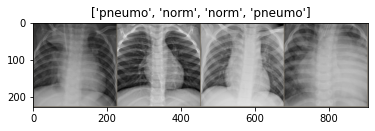

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Тренеруем модель
------------------


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Пункт 4
----------------------
Для пункта 4 ЛР нужно обучить на модели из туториала.

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Обучаем

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.6388 Acc: 0.6538
val Loss: 0.1726 Acc: 0.9103

Epoch 1/14
----------
train Loss: 0.3184 Acc: 0.8352
val Loss: 0.1313 Acc: 0.9615

Epoch 2/14
----------
train Loss: 0.3668 Acc: 0.8626
val Loss: 0.0708 Acc: 0.9615

Epoch 3/14
----------
train Loss: 0.2895 Acc: 0.8791
val Loss: 0.0702 Acc: 0.9615

Epoch 4/14
----------
train Loss: 0.3617 Acc: 0.8791
val Loss: 0.0229 Acc: 1.0000

Epoch 5/14
----------
train Loss: 0.5233 Acc: 0.8022
val Loss: 0.4713 Acc: 0.8077

Epoch 6/14
----------
train Loss: 0.1562 Acc: 0.9341
val Loss: 0.0859 Acc: 0.9615

Epoch 7/14
----------
train Loss: 0.2575 Acc: 0.9176
val Loss: 0.0785 Acc: 0.9615

Epoch 8/14
----------
train Loss: 0.1083 Acc: 0.9615
val Loss: 0.0675 Acc: 0.9744

Epoch 9/14
----------
train Loss: 0.0791 Acc: 0.9835
val Loss: 0.0546 Acc: 0.9872

Epoch 10/14
----------
train Loss: 0.2190 Acc: 0.9011
val Loss: 0.0563 Acc: 0.9744

Epoch 11/14
----------
train Loss: 0.1624 Acc: 0.9341
val Loss: 0.0697 Acc: 0.9744

Ep

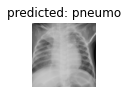

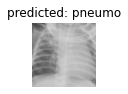

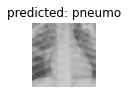

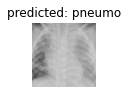

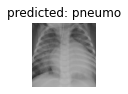

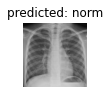

In [8]:
visualize_model(model_ft)

Пункт 5
----------------------
Реализуем свой класс MyDataset

In [9]:
from torch.utils.data import Dataset
from PIL import Image
import os

class MyDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = []
        self.annotations = []
        self.transform = transform
        for dir in os.scandir(path):
            if dir.is_dir():
                self.classes.append(dir.name)
                for im in os.scandir(dir.path):
                    if im.is_file():
                        self.annotations.append({'path': im.path, 'label': len(self.classes) - 1})

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        item = self.annotations[index]
        with open(item['path'], "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, item['label']

In [10]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

full_image_datasets = MyDataset(os.path.join('', 'chest_xray'),data_transform)

image_datasets_list = torch.utils.data.random_split(full_image_datasets, 
    [int(len(full_image_datasets) * 0.7), int(len(full_image_datasets) * 0.3)])

image_datasets = {'train': image_datasets_list[0],'val': image_datasets_list[1],}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = full_image_datasets.classes

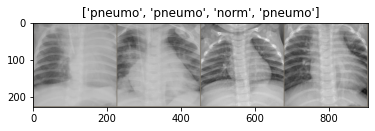

In [11]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Пункт 6
----------------------
Обучаем на своем датасате.

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)

Epoch 0/14
----------
train Loss: 0.4896 Acc: 0.7692
val Loss: 0.1095 Acc: 0.9615

Epoch 1/14
----------
train Loss: 0.3225 Acc: 0.8846
val Loss: 0.0991 Acc: 0.9872

Epoch 2/14
----------
train Loss: 0.2467 Acc: 0.9066
val Loss: 0.1695 Acc: 0.9487

Epoch 3/14
----------
train Loss: 0.2310 Acc: 0.9396
val Loss: 0.0863 Acc: 0.9872

Epoch 4/14
----------
train Loss: 0.2356 Acc: 0.9176
val Loss: 0.1389 Acc: 0.9487

Epoch 5/14
----------
train Loss: 0.3774 Acc: 0.8736
val Loss: 0.0778 Acc: 0.9872

Epoch 6/14
----------
train Loss: 0.2734 Acc: 0.8791
val Loss: 0.1454 Acc: 0.9487

Epoch 7/14
----------
train Loss: 0.1477 Acc: 0.9615
val Loss: 0.0695 Acc: 0.9615

Epoch 8/14
----------
train Loss: 0.0818 Acc: 0.9725
val Loss: 0.0938 Acc: 0.9744

Epoch 9/14
----------
train Loss: 0.3866 Acc: 0.8681
val Loss: 0.0774 Acc: 0.9744

Epoch 10/14
----------
train Loss: 0.1828 Acc: 0.9341
val Loss: 0.1683 Acc: 0.9615

Epoch 11/14
----------
train Loss: 0.1369 Acc: 0.9451
val Loss: 0.1461 Acc: 0.9615

Ep

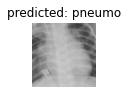

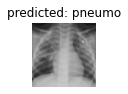

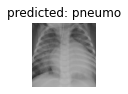

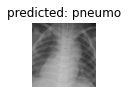

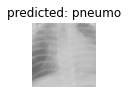

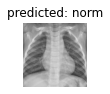

In [13]:
visualize_model(model_ft)

Пункт 7
--------------
Реализовать простейшую сеть MyConvNet из сверток\пулингов.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()

        # 3, 256, 256
        self.conv1 = nn.Conv2d(3, 6, 3) # 6, 254, 254
        self.pool1 = nn.MaxPool2d(2, 2) # 6, 127, 127
        self.conv2 = nn.Conv2d(6, 10, 5) # 10, 123, 123
        self.pool2 = nn.MaxPool2d(3, 3)  # 10, 41, 41
        self.conv3 = nn.Conv2d(6, 16, 3) # 16, 39, 39
        self.pool3 = nn.MaxPool2d(3, 3) # 16, 13, 13
        self.fc1 = nn.Linear(16*13*13, 200)
        self.fc2 = nn.Linear(200, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        # -> n, 3, 256, 256
        x = self.pool1(F.relu(self.conv1(x))) 
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 16*13*13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

 Пункт 8
 -----------------
 Обучаем нашу модель.
 

In [15]:
model = MyConvNet()
model = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=15)

Epoch 0/14
----------
train Loss: 0.3086 Acc: 0.8791
val Loss: 0.0591 Acc: 0.9744

Epoch 1/14
----------
train Loss: 0.1850 Acc: 0.9341
val Loss: 0.0667 Acc: 0.9744

Epoch 2/14
----------
train Loss: 0.4375 Acc: 0.8846
val Loss: 0.0616 Acc: 0.9872

Epoch 3/14
----------
train Loss: 0.1340 Acc: 0.9560
val Loss: 0.2318 Acc: 0.9359

Epoch 4/14
----------
train Loss: 0.1946 Acc: 0.9396
val Loss: 0.0924 Acc: 0.9615

Epoch 5/14
----------
train Loss: 0.5321 Acc: 0.8242
val Loss: 0.0883 Acc: 0.9615

Epoch 6/14
----------
train Loss: 0.2220 Acc: 0.9176
val Loss: 0.0627 Acc: 0.9872

Epoch 7/14
----------
train Loss: 0.1712 Acc: 0.9505
val Loss: 0.0946 Acc: 0.9744

Epoch 8/14
----------
train Loss: 0.2037 Acc: 0.9286
val Loss: 0.0647 Acc: 0.9872

Epoch 9/14
----------
train Loss: 0.1015 Acc: 0.9560
val Loss: 0.0748 Acc: 0.9744

Epoch 10/14
----------
train Loss: 0.1470 Acc: 0.9231
val Loss: 0.0742 Acc: 0.9744

Epoch 11/14
----------
train Loss: 0.0566 Acc: 0.9890
val Loss: 0.1158 Acc: 0.9615

Ep

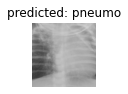

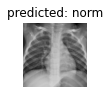

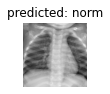

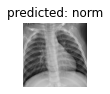

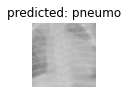

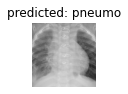

In [16]:
visualize_model(model)

Вывод
---------------
В данной работе я познакомился с торч фреймворком, понял как удобно в нем строить и обучать модели. Также познакомился с функциями обработки картинок и прочим полезными функционалом, который может в дальнейшем пригодиться в работе.